## Worksheet 2:  Run the Classification

This uses the data that was saved when the first worksheet was run and creates a classification.

The next cell can be used to set the number of university types, and the number and names of non-university organizations that should be used for the classification.

After computing the classification, the aggregated adjacency matrix is calculated, displayed and saved.  One version of the aggregate adjacency matrix is saved as a tex file called 'nice_adjacency_table.tex' in the current_estimates_and_files directory.  This way the table can be imported into the body of the paper when it is written.

The other version is saved in a serialized format in the file 'placement_rates.jld'.  This can be loaded directly into the next worksheet so that the classification doesn't have to be re-computed each time you work on the value estimation file.

The wordcloud versions of the top and second tiers aren't saved.  You'll have to add code if you want them.

In [1]:
using HTTP, JSON, PrettyTables, JLD, DotEnv, WordCloud, Random, Dates
DEBUG_LEVEL = 1
#if you want a list of universities in each tier set this to true
show_tier_members = false
include("functions/type_allocation_flexible.jl")
public_sector = ("Public Sector", Set())
private_sector = ("Private Sector", Set())
other_groups = ("Other Groups", Set())
postdocs = ("Postdocs", Set())
lecturers = ("Lecturers", Set())
other_academic = ("Other Academic", Set())
unmatched = ("Unmatched", Set())
# choose the number of academic types
NUMBER_OF_TYPES = 5
# choose which of the sets declared above your want to include in the classification
sinks_to_include = (public_sector, private_sector,postdocs,lecturers,unmatched, other_groups);
# teaching universities are discovered by finding institutions that hire but  never graduate, so they are added automatically
NUMBER_OF_SINKS = length(sinks_to_include)+1
numtotal = NUMBER_OF_TYPES + NUMBER_OF_SINKS
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]
# check mysql database econjobmarket research table algorithm_runs for information about the date when the 
# data was assembled this is the primary key id of this entry
algorithm_run_id = 6

6

In [2]:
# designed to fetch data from disk
# currently run mike_assemble_data.ipynb to refresh data from the api source
to_from_by_year_api = SBM_flexible.fetch_data(files_path*"to_from_by_year.json");

In [3]:
# the number of placements im ocean and crow - currently a proxy for failed trades
n = 0
m = 0
for (key,value) in  to_from_by_year_api
    for (k,v) in value
        if v["to_institution_id"] == 754
           n += 1
        end
    end
end
println(n)

3085


In [4]:
academic, academic_to, academic_builder, rough_sink_builder, institution_mapping, reverse_mapping = SBM_flexible.get_builders(to_from_by_year_api);

In [5]:
#save(files_path*"/academic_builder.jld", "academic_builder", academic_builder)

In [6]:
# sink of teaching universities that do not graduate PhDs
# this must be constructed using academic placements, not pre-defined sink placements

teaching_universities = Set() 
for dept_name in academic_to
    if !(dept_name in academic)
        # the department hired an assistant professor but never graduated anyone
        push!(teaching_universities, dept_name)
    end
end
println(length(teaching_universities))
save(files_path*"/teaching_universities.jld", "teaching_universities", teaching_universities)


for outcome in rough_sink_builder
    if outcome["disappeared"] == 1 #untrackable applicants
        #push!(unmatched[2], (string(outcome["to_name"], " ($(unmatched[1]))"), outcome))
        push!(unmatched[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] == 5 # government institution
        #push!(public_sector[2], (string(outcome["to_name"], " ($(public_sector[1]))"), outcome))
        push!(public_sector[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] in [6, 7, 6, 7, 9, 10, 11] # private sector: for and not for profit
        #push!(private_sector[2], (string(outcome["to_name"], " ($(private_sector[1]))"), outcome))
        push!(private_sector[2], (outcome["to_name"], outcome))
    elseif outcome["recruiter_type"] == 8 # international organizations, think tanks, assorted
        #push!(other_groups[2], (string(outcome["to_name"], " ($(other_groups[1]))"), outcome))
        push!(other_groups[2], (outcome["to_name"], outcome))

    # some other examples
    # every example here must also have a corresponding sink Set() above, 
    #     and an entry in sinks_to_include below
   
    elseif outcome["postype"] == 6
        # postdocs that are not in the above (i.e. academic; not public, private, or other)
        # requires reconfiguration of the to_from_by_year loading code
        #push!(postdocs[2], (string(outcome["to_name"], " ($(postdocs[1]))"), outcome))
        push!(postdocs[2], (outcome["to_name"], outcome))
    elseif outcome["postype"] in [5, 7]
        # lecturers that are not in the above
        # requires reconfiguration of the to_from_by_year loading code
        #push!(lecturers[2], (string(outcome["to_name"], " ($(lecturers[1]))"), outcome))
        push!(lecturers[2], (outcome["to_name"], outcome))
    else
        # everything else including terminal academic positions
        # this sink can only be constructed as an "else" statement
        #push!(other_academic[2], (string(outcome["to_name"], " ($(other_academic[1]))"), outcome))
        push!(other_academic[2], (outcome["to_name"], outcome))
    
    end
end

# sort to ensure consistent ordering
academic_list = sort(collect(academic))
teaching_list = sort(collect(teaching_universities))
# to be consistent with the original estimation, we only include these additional sinks:


sink_builder, sinks, sink_labels = SBM_flexible.build_sinks(sinks_to_include, teaching_list)

institutions = vcat(academic_list, sinks...)
println("$(length(academic_list)) academic departments, $(length(institutions)) total departments")

663
Including the following sinks:
 Public Sector
 Private Sector
 Postdocs
 Lecturers
 Unmatched
 Other Groups
 Teaching Universities
Total 7 sinks
1181 academic departments, 3376 total departments


In [7]:
filtered_data = copy(academic_builder)
m = 0
for (x,t) in sink_builder
   push!(filtered_data, t)
end


#println(length(academic_builder) + length(sink_builder))
println(length(filtered_data))
#sink_labels

18998


In [8]:
save(files_path*"/filtered_data.jld", "filtered_data", filtered_data)

In [9]:
out = SBM_flexible.get_adjacency(academic_list, institutions, academic_builder, sink_builder);

Total 18998 Placements (found 18998 by sequence counting, 18998 by matrix sum)


In [10]:
using Optim, Random
Random.seed!(0)

TaskLocalRNG()

In [11]:
function β(K, likelihoods, λ, numtotal_test, n)
    return likelihoods[K] - λ * ((K * numtotal_test) / 2) * n * log(n)
end

function w(β_vec)
    return β_vec ./ sum(β_vec)
end

function objective_to_minimize(λ_vec, range_K, likelihoods, numsink, n)
    λ = λ_vec[1] # just 1-D
    if λ < 0 
        return Inf 
    end
    w_vec = w([β(K, likelihoods, λ, K + numsink, n) for K in range_K])
    return sum(w_vec .* log.(w_vec))
end

objective_to_minimize (generic function with 1 method)

In [12]:
Random.seed!(0) # for reproducibility
@time est_obj, est_alloc = SBM_flexible.doit(out, length(academic_list), [length(s) for s in sinks], NUMBER_OF_TYPES, numtotal, 500 * (NUMBER_OF_TYPES-2) + 1000)

1090.313849 seconds (383.57 k allocations: 20.028 MiB, 0.01% compilation time)


(41295.16755864648, Int32[3, 5, 5, 4, 4, 4, 4, 4, 4, 4  …  12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [13]:
placement_rates, counts, sorted_allocation, full_likelihood = 
SBM_flexible.get_allocation(est_alloc, out, NUMBER_OF_TYPES, numtotal, institutions);

debug bas line 295 
Int32[982 990 122 8 323; 368 1232 49 0 182; 567 281 471 43 462; 47 8 44 162 51; 1440 1071 156 33 1025; 599 577 70 20 293; 459 791 77 28 253; 159 87 65 29 143; 73 35 50 54 76; 746 409 580 441 950; 180 212 35 9 98; 375 234 179 70 425]
Int32[3844 1240 21824 35216 11098; 1240 400 7040 11360 3580; 21824 7040 123904 199936 63008; 35216 11360 199936 322624 101672; 11098 3580 63008 101672 32041; 9858 3180 55968 90312 28461; 15810 5100 89760 144840 45645; 39370 12700 223520 360680 113665; 27466 8860 155936 251624 79297; 62 20 352 568 179; 2418 780 13728 22152 6981; 41106 13260 233376 376584 118677]


In [14]:
#save(files_path*"/est_mat.jld",
 #   "est_mat", est_mat)
placement_rates

12×5 Matrix{Int32}:
 1232   368   182   49    0
  990   982   323  122    8
 1071  1440  1025  156   33
  281   567   462  471   43
    8    47    51   44  162
  577   599   293   70   20
  791   459   253   77   28
   87   159   143   65   29
   35    73    76   50   54
  409   746   950  580  441
  212   180    98   35    9
  234   375   425  179   70

In [15]:

save(files_path*"/sinks.jld", "sinks", sinks)

In [16]:
unmatched_index = 0
counter = zeros(Int64,NUMBER_OF_TYPES+NUMBER_OF_SINKS);
for sorted_type in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS
    #counter = 0
    inst_hold = []
    println("TYPE $sorted_type:")
    for (i, sbm_type) in enumerate(sorted_allocation)
        if sbm_type == sorted_type
            push!(inst_hold, institutions[i])
            counter[sorted_type] += 1
        end
    end
    if show_tier_members
        for inst in sort(inst_hold)
        println("  ", inst)
        end
    end
    println("Total Institutions: ",counter[sorted_type])
    if counter[sorted_type] == 1
        unmatched_index = sorted_type
    end
    println()
end
println( "Unmatched Index ", unmatched_index)

TYPE 1:
Total Institutions: 20

TYPE 2:
Total Institutions: 62

TYPE 3:
Total Institutions: 179

TYPE 4:
Total Institutions: 352

TYPE 5:
Total Institutions: 568

TYPE 6:
Total Institutions: 159

TYPE 7:
Total Institutions: 255

TYPE 8:
Total Institutions: 635

TYPE 9:
Total Institutions: 443

TYPE 10:
Total Institutions: 1

TYPE 11:
Total Institutions: 39

TYPE 12:
Total Institutions: 663

Unmatched Index 10


In [17]:
# define row titles for the adjacency matrix, include institution counts
names = []

for i in 1:NUMBER_OF_TYPES + NUMBER_OF_SINKS
    if i <= NUMBER_OF_TYPES
        push!(names,string("TYPE ", i, " (", counter[i]," insts)"))
    else
        push!(names, string(sink_labels[i - NUMBER_OF_TYPES], " (", counter[i]," insts)"))
    end
#counter\
end


In [18]:
classification_properties = Dict("algorithm_run_id" => algorithm_run_id, 
    "institution_counts" => counter, "num_years" => length(to_from_by_year_api),
    "row_labels" => names,
    "data_loaded" => Dates.unix2datetime(mtime(files_path*"to_from_by_year.json")),
    "unmatched_index" => unmatched_index, "number_of_academic_types" => NUMBER_OF_TYPES)
save(files_path*"classification_properties.jld", "classification_properties", classification_properties)

In [19]:
# define row titles for the adjacency matrix, include institution counts
names = []

for i in 1:NUMBER_OF_TYPES + NUMBER_OF_SINKS
    if i <= NUMBER_OF_TYPES
        push!(names,string("TYPE ", i, " (", counter[i]," insts)"))
    else
        push!(names, string(sink_labels[i - NUMBER_OF_TYPES], " (", counter[i]," insts)"))
    end
#counter\
end
SBM_flexible.nice_adjacency_table(placement_rates, names)

┌───────────────────────────────────┬────────┬────────┬────────┬────────┬────────┬────────────┐
│                                   │ Tier 1 │ Tier 2 │ Tier 3 │ Tier 4 │ Tier 5 │ Row Totals │
├───────────────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────────┤
│                 TYPE 1 (20 insts) │   1232 │    368 │    182 │     49 │      0 │       1831 │
│                 TYPE 2 (62 insts) │    990 │    982 │    323 │    122 │      8 │       2425 │
│                TYPE 3 (179 insts) │   1071 │   1440 │   1025 │    156 │     33 │       3725 │
│                TYPE 4 (352 insts) │    281 │    567 │    462 │    471 │     43 │       1824 │
│                TYPE 5 (568 insts) │      8 │     47 │     51 │     44 │    162 │        312 │
│         Public Sector (159 insts) │    577 │    599 │    293 │     70 │     20 │       1559 │
│        Private Sector (255 insts) │    791 │    459 │    253 │     77 │     28 │       1608 │
│              Postdocs (635 insts) │   

In [20]:
length(unmatched[2])

57

In [21]:
type_dictionary = []
for (i, alloc) in enumerate(sorted_allocation)
    if alloc in 1:NUMBER_OF_TYPES
        inst_id = reverse_mapping[institutions[i]]
        push!(type_dictionary, Dict("name" => institutions[i], "institution_id" => inst_id, "type" => alloc))
    end
end

In [22]:
open(files_path*"id_to_type_api.json", "w") do f
    write(f, JSON.json(type_dictionary))
end;

In [23]:
SBM_flexible.nice_adjacency_table(placement_rates,names, files_path*"nice_adjacency_table.tex")

In [24]:
#save the adjacency matrix to pass on to the value estimates file
save(files_path*"/placement_rates.jld", "placement_rates", placement_rates)
save(files_path*"row_names.jld", "names", names)


Total words: 21.0. Unique words: 21. After filtration: 16.
The top 16 words are kept. 
color scheme: :Paired_3, random size: 3, shuffled
angles = 30:-15:-30
backgroundcolor = :maskcolor
shape(ellipse, 240, 204, color=1.0, padding=19, outline=9, linecolor=RGB{Float64}(0.651,0.808,0.89))
fonts = "STSong Regular"
mask size: 260×296, volume: 195² (49²/word)
set fontsize ∈ [8.0, 260]
set density = 0.5
⋯scale=54.50200684378512, density=0.6172360738519805	↑
⋯scale=49.05370850793452, density=0.5093206564620483	↑
fontsize ∈ [9.582398214447151, 23.860358492612423]


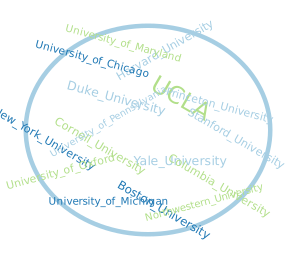

In [25]:
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 1
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)


In [26]:
generate!(wc)
paint(wc, ".estimates/type1.svg")
#words

▸1. Set spacing = 2; scale = 48.55446575369974
Aborted after 130 epochs.
▸2. Try setting spacing = 1
Aborted after 167 epochs.
▸3. Try setting scale = 47.09783178108874. The density will be reduced to 0.4692070380306139
fontsize ∈ [9.294926268013736, 23.14454773783405]
Failed after 292 epochs.
These words collide: UCLA & University_of_Pennsylvania, Harvard_University & University_of_Chicago, Cornell_University & New_York_University, Cornell_University & University_of_Oxford, Stanford_University & Northwestern_University, Stanford_University & University_of_Pennsylvania, University_of_Michigan & Northwestern_University, 


┌ Warning: Have 7 collisions. Try setting a larger `epochs` and `retry`, or lower `density` and `spacing` in `wordcloud` to fix it.
└ @ WordCloud ~/.julia/packages/WordCloud/G3Rci/src/wc-method.jl:276


Total words: 69.0. Unique words: 69. After filtration: 59.
The top 59 words are kept. 
color scheme: :Set2_5, random size: 4
angles = 90:-15:-90
shape(squircle, 535, 337, rt=0.594, color=1.0, padding=40)
fonts = "Courier Medium"
mask size: 417×615, volume: 402² (52²/word)
set fontsize ∈ [8.0, 417]
set density = 0.5
⋯scale=58.53960704702705, density=0.6429142684035141	↑
⋯scale=51.62478700900807, density=0.4898988556343471	↓
fontsize ∈ [9.717876165626151, 28.011672085580194]
gathering style: use the parameter in wordcloud `:rt=>0.594`


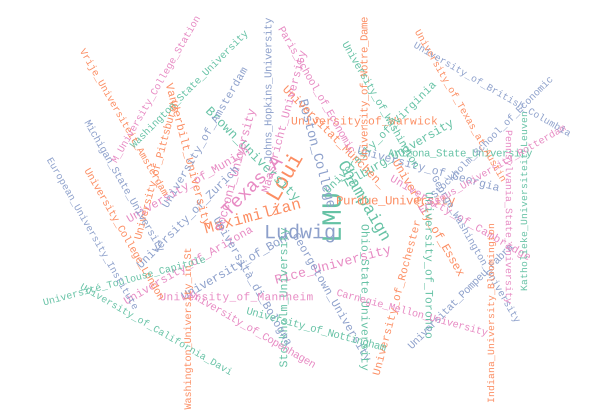

In [27]:
using WordCloud, Random
words = ""
weights = []

for inst in type_dictionary
    if inst["type"] == 2
        temp_word = replace(inst["name"], " " => "_")
        words = words * replace(temp_word,"," => "") * " "
        push!(weights, length(inst["name"]))
    end
end

wc = wordcloud(words)
